In [8]:
from functools import partial
from itertools import product

import cupy as cp
import matplotlib.pyplot as plt

from superfv import EulerSolver, OutputLoader
from superfv.initial_conditions import gresho_vortex
from superfv.slope_limiting.zhang_and_shu import compute_theta

In [2]:
N = 96
gamma = 5 / 3
v0 = 5.0
M_max = 0.001

base_path = f"/scratch/gpfs/jp7427/out/gresho-vortex/v0_{v0}/"

In [3]:
common = dict(PAD={"rho": (0, None), "P": (0, None)})
apriori = dict(ZS=True, lazy_primitives="adaptive", **common)
aposteriori = dict(
    MOOD=True,
    face_fallback=False,
    lazy_primitives="full",
    MUSCL_limiter="PP2D",
    **common,
)
aposteriori1 = dict(cascade="muscl", max_MOOD_iters=1, **aposteriori)
aposteriori2 = dict(cascade="muscl1", max_MOOD_iters=2, **aposteriori)
aposteriori3 = dict(cascade="muscl1", max_MOOD_iters=3, **aposteriori)

In [4]:
config = dict(p=3, GL=True, **apriori)
sim = EulerSolver(
    ic=partial(gresho_vortex, gamma=gamma, M_max=M_max, v0=v0),
    gamma=gamma,
    nx=N,
    ny=N,
    cupy=True,
    **config,
)

old_sim3 = OutputLoader(f"{base_path}p3/M_max_{M_max}")
old_sim7 = OutputLoader(f"{base_path}p7/M_max_{M_max}")

/home/jp7427/Desktop/superfv/superfv/finite_volume_solver.py:414: UserWarning: CuPy is not available. Using NumPy instead.
  warnings.warn("CuPy is not available. Using NumPy instead.")


Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/p3/M_max_0.001"
Successfully read simulation output from "/scratch/gpfs/jp7427/out/gresho-vortex/v0_5.0/p7/M_max_0.001"


In [5]:
def test_compute_theta(u, sim):
    t = sim.t
    scheme = sim.base_scheme
    mesh = sim.mesh
    xp = sim.xp

    primitives = True

    w = sim.arrays["_w_"] if primitives else sim.arrays["_u_"]
    wcc = sim.arrays["_wcc_"] if primitives else sim.arrays["_ucc_"]
    wx = sim.arrays["_x_nodes_"] if mesh.x_is_active else None
    wy = sim.arrays["_y_nodes_"] if mesh.y_is_active else None
    wz = sim.arrays["_z_nodes_"] if mesh.z_is_active else None
    theta = sim.arrays["_theta_"]
    dmp = sim.arrays["_dmp_"]
    alpha = sim.arrays["_alpha_"]
    buffer = sim.arrays["_buffer_"]

    sim.update_workspaces(t, xp.asarray(u), scheme)

    sim.interpolate_faces(sim.arrays["_u_"], "x", scheme, convert_to_primitives=True)
    sim.interpolate_faces(sim.arrays["_u_"], "y", scheme, convert_to_primitives=True)

    compute_theta(
        xp,
        w,
        wcc,
        wx,
        wy,
        wz,
        out=theta,
        dmp=dmp,
        alpha=alpha,
        buffer=buffer,
        config=scheme.limiter_config,
    )

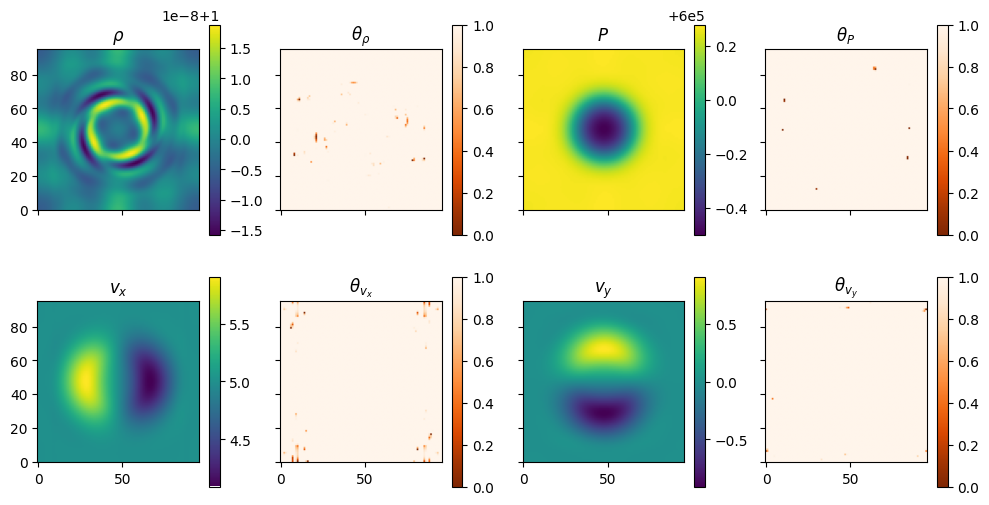

In [9]:
test_compute_theta(old_sim3.snapshots[-1]["u"], sim)

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6))
axs[0, 0].set_title(r"$\rho$")
axs[0, 2].set_title(r"$P$")
axs[1, 0].set_title(r"$v_x$")
axs[1, 2].set_title(r"$v_y$")
axs[0, 1].set_title(r"$\theta_{\rho}$")
axs[0, 3].set_title(r"$\theta_{P}$")
axs[1, 1].set_title(r"$\theta_{v_x}$")
axs[1, 3].set_title(r"$\theta_{v_y}$")

idx = sim.variable_index_map

style = dict(origin="lower", cmap="viridis")
axs[0, 0].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("rho")][:, :, 0], **style
)
axs[0, 2].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("P")][:, :, 0], **style
)
axs[1, 0].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("vx")][:, :, 0], **style
)
axs[1, 2].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("vy")][:, :, 0], **style
)

style = dict(origin="lower", cmap="Oranges_r")
axs[0, 1].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("rho")][:, :, 0], **style
)
axs[0, 3].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("P")][:, :, 0], **style
)
axs[1, 1].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("vx")][:, :, 0], **style
)
axs[1, 3].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("vy")][:, :, 0], **style
)

for i, j in product(range(2), range(4)):
    plt.colorbar(axs[i, j].images[0], ax=axs[i, j])

In [ ]:
fig.savefig("p3_theta.pdf", bbox_inches="tight")

In [ ]:
test_compute_theta(old_sim7.snapshots[-1]["u"], sim)

fig, axs = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(12, 6))
axs[0, 0].set_title(r"$\rho$")
axs[0, 2].set_title(r"$P$")
axs[1, 0].set_title(r"$v_x$")
axs[1, 2].set_title(r"$v_y$")
axs[0, 1].set_title(r"$\theta_{\rho}$")
axs[0, 3].set_title(r"$\theta_{P}$")
axs[1, 1].set_title(r"$\theta_{v_x}$")
axs[1, 3].set_title(r"$\theta_{v_y}$")

idx = sim.variable_index_map

style = dict(origin="lower", cmap="viridis")
axs[0, 0].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("rho")][:, :, 0], **style
)
axs[0, 2].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("P")][:, :, 0], **style
)
axs[1, 0].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("vx")][:, :, 0], **style
)
axs[1, 2].imshow(
    cp.asnumpy(sim.arrays["_w_"])[sim.interior][idx("vy")][:, :, 0], **style
)

style = dict(origin="lower", cmap="Oranges_r")
axs[0, 1].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("rho")][:, :, 0], **style
)
axs[0, 3].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("P")][:, :, 0], **style
)
axs[1, 1].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("vx")][:, :, 0], **style
)
axs[1, 3].imshow(
    cp.asnumpy(sim.arrays["_theta_"])[sim.interior][idx("vy")][:, :, 0], **style
)

for i, j in product(range(2), range(4)):
    plt.colorbar(axs[i, j].images[0], ax=axs[i, j])

In [ ]:
fig.savefig("p7_theta.pdf", bbox_inches="tight")